
[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Data loaded successfully!
✅ Model training complete!


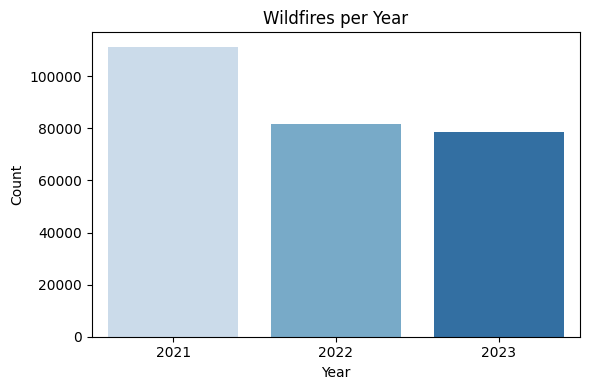

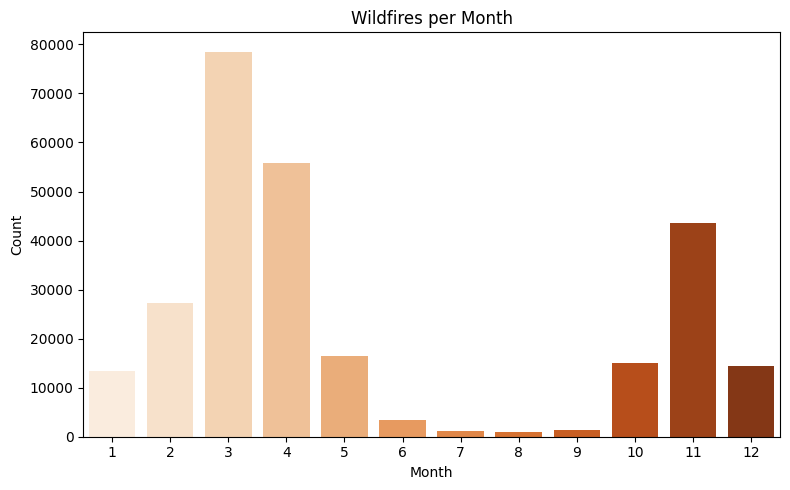

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     51526
           2       0.95      0.79      0.86      2710
           3       1.00      0.75      0.86         8

    accuracy                           0.99     54244
   macro avg       0.98      0.85      0.90     54244
weighted avg       0.99      0.99      0.99     54244



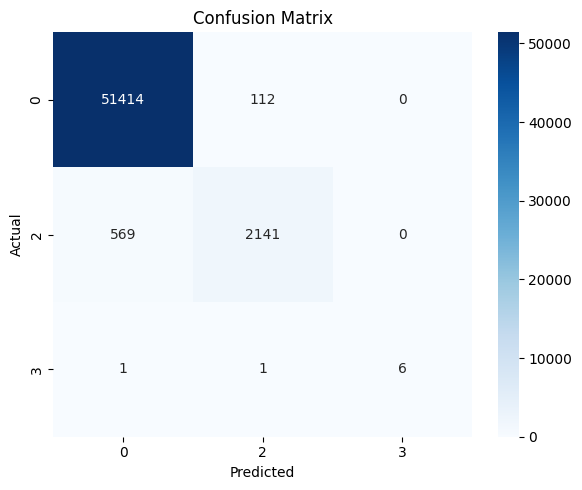

In [1]:
# STEP 1: INSTALL LIBRARY
!pip install xgboost --quiet

# STEP 2: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# STEP 3: LOAD CSV FILES
try:
    df_2021 = pd.read_csv('modis_2021_India.csv')
    df_2022 = pd.read_csv('modis_2022_India.csv')
    df_2023 = pd.read_csv('modis_2023_India.csv')
    df = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)
    print("✅ Data loaded successfully!")
except Exception as e:
    print(f"❌ Error loading CSV files: {e}")
    raise SystemExit()

# STEP 4: PREPROCESSING
df['acq_date'] = pd.to_datetime(df['acq_date'], errors='coerce')
df['year'] = df['acq_date'].dt.year
df['month'] = df['acq_date'].dt.month
df.dropna(inplace=True)

# Features and Target
X = df.drop(columns=['type', 'acq_date', 'acq_time'])
y = df['type']

# Encode y to avoid class mismatch errors
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_names = [str(label) for label in le.classes_]  # Convert to strings for report

# Column types
cat_features = ['daynight', 'satellite', 'instrument']
num_features = [col for col in X.columns if col not in cat_features]

# Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

pipeline.fit(X_train, y_train)
print("✅ Model training complete!")

# STEP 5: OUTPUTS
y_pred = pipeline.predict(X_test)

# Output 1: Wildfires per year
plt.figure(figsize=(6, 4))
sns.countplot(x='year', data=df, palette='Blues')
plt.title('Wildfires per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Output 2: Wildfires per month
plt.figure(figsize=(8, 5))
sns.countplot(x='month', data=df, palette='Oranges')
plt.title('Wildfires per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Output 3: Classification report
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_names))

# Output 4: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
